In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import integrate

%matplotlib inline

[[1510594080346.5 -1.1769999999999998 -6.932 6.353000000000001]]


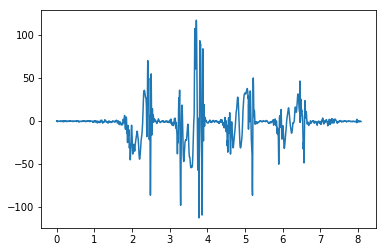

In [58]:
file = 'datas/walk40hz.tsv'
sep = '\t'
data = pd.read_csv(file, sep)
data = data.as_matrix()[:, 1:5]

means = np.mean(data[0:10, :], axis=0, keepdims=True)
print(means)

data[:, 0] = (data[:, 0] - data[0, 0]) / 1000.0 # timestamp -> microsecond -> second
data[:, 1:4] = (data[:, 1:4] - means[0, 1:4]) * 9.8 # g to m/s^2

plt.plot(data[:, 0], data[:, 1])

[[  4.54753991e+00   4.61530130e-01   2.35328664e-01   2.91795023e-03]]


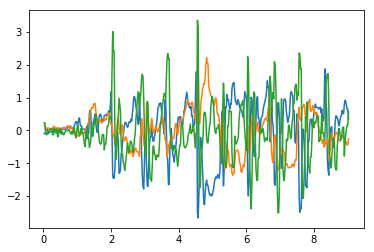

In [2]:
file = 'datas/walk_3.csv'
sep = ','
data = pd.read_csv(file, sep)
data = data.as_matrix()
data = data[~np.isnan(data).any(axis=1)] # remove row contains nan value

data[:, 3] = data[:, 3] - 9.8
means = np.mean(data, axis=0, keepdims=True)
print(means)

data[:, 1:4] = data[:, 1:4] - means[:, 1:4]

plt.plot(data[:, 0], data[:, 1:4])

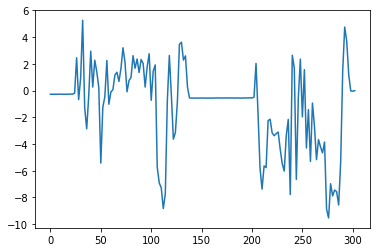

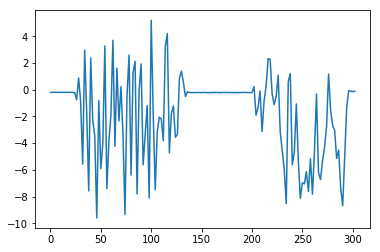

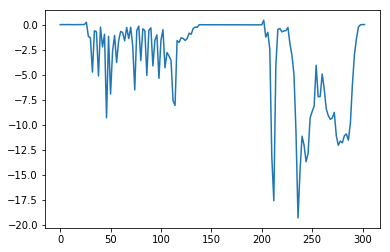

In [32]:
file = 'datas/real_data_1.csv'
sep = ','
data = pd.read_csv(file, sep)
data = data.as_matrix()

time = data[:, 1]
axis_x = np.arange(start=0, stop=2*len(x_accel), step=2)
x_accel = data[:, 2] * 9.81
y_accel = data[:, 3] * 9.81
z_accel = data[:, 4] * 9.81 - 9.81

plt.plot(axis_x, x_accel)
plt.show()
plt.plot(axis_x, y_accel)
plt.show()
plt.plot(axis_x, z_accel)
plt.show()

In [3]:
class KalmanFilter:
    '''
    Ref: https://malcolmmielle.wordpress.com/2015/04/29/kalman-filter/
    '''
    
    def __init__(self, q, r, p):
        '''
        _q: process noise covariance
        _q_init
        _r: measurement noise covariance
        _r_init
        _p: estimation error covariance
        _p_init
        _x: value
        _k: Kalman gain
        '''
        self._q = float(q)
        self._q_init = float(q)
        self._r = float(r)
        self._r_init = float(r)
        self._x = 0
        self._p = float(p)
        self._p_init = float(p)
        self._k = float(p / (p + r))
        
    
    def init_value(self, x):
        self._x = float(x)
        
    def set_process_noise_covariance(self, i):
        self._q = float(i)
        self._q_init = float(i)
        
    def set_measurement_noise_covariance(self, i):
        self._r = float(i)
        self._r_init = float(i)
        
    def set_estimation_error_covariance(self, i):
        self._p = float(i)
        self._p_init = float(i)
        
    def kalman_update(self, measurement):
        # prediction update
        self._p = self._p + self._q
        
        # measurement update
        self._k = self._p / (self._p + self._r)
        self._x = self._x + self._k * (measurement - self._x)
        self._p = (1 - self._k) * self._p
        
        return self._x
    
    def reset(self):
        self._q = self._q_init
        self._r = self._r_init
        self._p = self._p_init
        

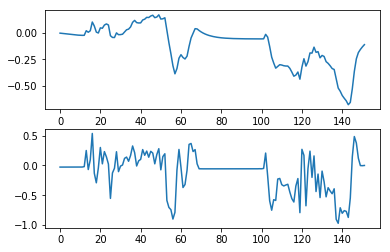

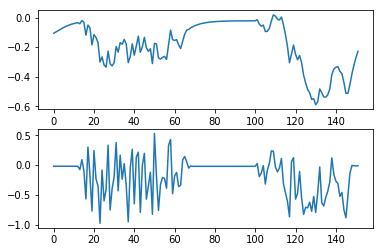

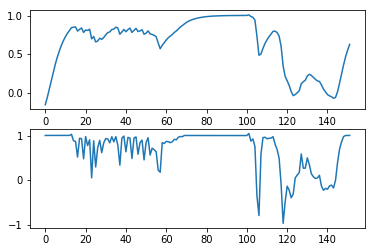

In [27]:
# Create KalmanFilter instance
q = 1
r = 32
p = 1
kfilter = KalmanFilter(q, r, p)

# Filter acceleration data
filtered_data = np.zeros((data.shape[0], 3))
for i in range(3):
    for j in range(data.shape[0]):
        filtered_data[j, i] = kfilter.kalman_update(data[j, i+2])
#         filtered_data[j, i] = kfilter.kalman_update(filtered_data[j, i])
    
    # Plot data
    plt.figure(i+1)
    plt.subplot(211)
    plt.plot(axis_x, filtered_data[:, i])
    plt.subplot(212)
    plt.plot(axis_x, data[:, i+2])
    
    # Reset the filter
    kfilter.reset()


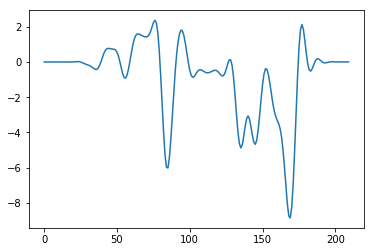

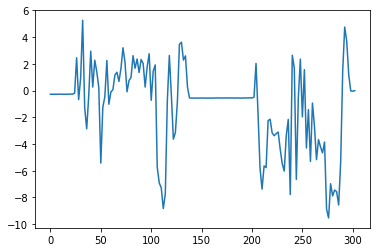

In [39]:
# Example code, computes the coefficients of a low-pass windowed-sinc filter.

# Configuration.
fL = 0.1  # Cutoff frequency as a fraction of the sampling rate.
N = 59  # Filter length, must be odd.

# Compute sinc filter.
h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))

# Apply window.
h *= np.blackman(N)

# Normalize to get unity gain.
h /= np.sum(h)

# print(h)

# Applying the filter to a signal s can be as simple as writing
s = np.convolve(x_accel, h)

plt.plot(np.arange(len(s)), s)
plt.show()
plt.plot(axis_x, x_accel)
plt.show()

### Acceleration to distance

https://docs.scipy.org/doc/scipy/reference/integrate.html

https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html

https://engineersportal.com/blog/2017/9/25/accelerometer-on-an-elevator

https://www.researchgate.net/post/Calculating_Speed_and_Distance_from_a_3-axis_accelerometer

https://github.com/clemaitre58/Accelerometer_integration

https://www.nxp.com/docs/en/application-note/AN3397.pdf


(210,)
(210,)
(210,)


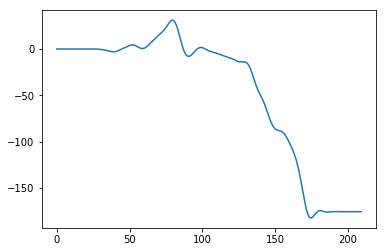

In [44]:
# acceleration data -> velocity -> distance

time = data[:, 0]
x_accel = filtered_data[:, 0]
x_velo = integrate.cumtrapz(x_accel, time, initial=0)
x_dist = integrate.cumtrapz(x_velo, time, initial=0)

print(time.shape)
print(x_velo.shape)
print(x_dist.shape)

# x_dist = integrate.simps(x_velo, time)
# plt.plot(time, x_accel)
plt.plot(time, x_velo)
# plt.plot(time, x_dist)

In [194]:
delta_x = np.mean(np.diff(time))
dx = delta_x.total_seconds()

AttributeError: 'numpy.float64' object has no attribute 'total_seconds'

### Final model